# EMA Crossover Strategy Modeling

In [257]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import random
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import mplfinance as mpf
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import timedelta
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter

In [229]:
def get_sp500_tickers():
    url = 'https://www.slickcharts.com/sp500'
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text
    table = pd.read_html(str(BeautifulSoup(html, 'lxml').find('table')))[0]
    return table['Symbol'].str.replace('.', '-', regex=False).tolist()

tickers = get_sp500_tickers()
df = yf.download(tickers, start='2010-01-01', end='2025-04-22', group_by='ticker', auto_adjust=True)

C:\Users\rusla\AppData\Local\Temp\ipykernel_38044\631629297.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(BeautifulSoup(html, 'lxml').find('table')))[0]
[*********************100%***********************]  503 of 503 completed


In [230]:
# Multi to singlular column transformation
df.columns = df.columns.swaplevel(0, 1)
df_flat = df.stack(level=1, future_stack=True).reset_index()
df_flat.columns.name = None
df_flat.columns = [col if not isinstance(col, tuple) else col[-1] for col in df_flat.columns]
df_flat.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2010-01-04,PHM,8.600334,8.806329,8.574583,8.789163,6121300.0
1,2010-01-04,BLDR,3.930000,3.930000,3.750000,3.770000,494400.0
2,2010-01-04,URI,9.670518,9.875237,9.543788,9.787500,1692500.0
3,2010-01-04,POOL,15.746689,15.852480,15.583932,15.738551,217100.0
4,2010-01-04,BLK,158.998285,161.389492,157.294131,160.702438,238700.0


In [231]:
df_flat.dropna(inplace=True)
df_flat.isnull().sum()

Date      0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Technical Indicators

- __RSI (Relative Strength Index):__ Measures the speed and magnitude of recent price changes to identify overbought (>70) or oversold (<30) conditions.

    - If RSI > 50 then uptrend is gaining strength
    - If RSI < 50 then momentum is weakening

<br>

- __MACD (Moving Average Convergence Divergence):__ Captures the difference between short and long term momentum via EMAs.

    - MACD = EMA12 - EMA26
    - Signal line = EMA9 of MACD
    - macd > signal = bullish momentum

<br>

- __ATR (Average True Range):__  Is a volatility indicator that reflects the average price variation of an asset.

    - Calculates the maximum of high-low, high-previous close, and low-previous close
    - Averages this over a rolling window, usually set to 14 days
    - Higher ATR can indicate breakout potential or stop-loss placement zones

<br>

- __CCI (Commodity Channel Index):__ Detects price deviations from a statistical mean.

    - Computes the typical price = (High + Low + Close) / 3
    - Measures how far the typical price deviates from its moving average
    - CCI > +100 suggests strong bullish deviation
    - CCI < -100 implies a potential trend reversal

<br>

- __HMA (Hull Moving Average):__ Is a smoother, faster reacting moving average used to reduce lag.

    - Combines weighted averages of two rolling means
    - Applies a square root weighted smoothing

In [233]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(df):
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_atr(df, period=14):
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['Close'].shift()).abs()
    low_close = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def calculate_cci(df, period=20):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(window=period).mean()
    mad = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
    cci = (tp - sma) / (0.015 * mad)
    return cci

def calculate_hma(close, period=20):
    half = close.rolling(window=period//2).mean()
    full = close.rolling(window=period).mean()
    raw_hma = 2 * half - full
    hma = raw_hma.rolling(window=int(np.sqrt(period))).mean()
    return hma


## Feature Engineering

- __EMA10, EMA20, EMA50, EMA200:__ Exponential moving averages over different spans, these provide smoothed price trends, with the 50/200 pair used to detect "golden cross" signals.

- __momentum_5:__ Percentage change over the last 5 days, a simple measure of short term momentum or trend acceleration.

- __ema_distance:__ Difference between EMA50 and EMA200, helps quantify how far the two EMAs have diverged.

- __ema50_slope:__ 5 day slope of the EMA50 line, provides insight into the trajectory and speed of trend development.

- __price_ema200_dist:__ Distance between the current close and EMA200.

- __EMA50_prev/EMA200_prev:__ Shifted versions of EMA50 and EMA200, used to identify crossovers.

- __RSI_14:__ 14 day Relative Strength Index, gauges overbought or oversold conditions.

- __MACD/MACD_signal:__ MACD and its signal line.

- __macd_diff:__ Difference between MACD and its signal line, indicates strength of the MACD trend.

- __ATR_14:__ Average True Range over 14 days, measuring volatility.

- __CCI_20:__ Commodity Channel Index over 20 days, another momentum indicator.

- __BB_MID/BB_UPPER/BB_LOWER:__ Bollinger Bands based on 20 day mean and standard deviation.

- __HMA_20:__ Hull Moving Average with 20 period window.

<br>

__Labeling Strategy:__ Used a hybrid logic for labeling crossover signals as profitable (1) or not profitable (0)
- __forward_return:__ The 10 day forward return is calculated as the percentage return from the current date to 10 trading days ahead.
- __Label = 1:__
    - If the forward return exceeds +3% OR
    - If the crossover is supported by bullish MACD and RSI momentum (MACD > MACD Signal & RSI > 50)
- __Label = 0:__ All other cases

- *Why did I end up using this strategy over a standard label that took `forward_return` > 0.3?*
    - It mislabeled "slow" crossovers that took longer to become profitable as "0"
    - Mislabeled "bad" crossovers as good due to short term volatility
    - Saw many signals labeled as "bad" were actually good in hindsight if held longer, also saw "good" labeled signals showing brief momentum and then failing


In [235]:
# FEATURE ENGINEERING
df_flat['EMA10'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
df_flat['EMA20'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
df_flat['EMA50'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=50).mean())
df_flat['EMA200'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=200).mean())

df_flat['momentum_5'] = df_flat.groupby('Ticker')['Close'].pct_change(5, fill_method=None)

df_flat['ema_distance'] = df_flat['EMA50'] - df_flat['EMA200']

df_flat['ema50_slope'] = df_flat.groupby('Ticker')['EMA50'].diff(5)

df_flat['price_ema200_dist'] = df_flat['Close'] - df_flat['EMA200']

df_flat['EMA50_prev'] = df_flat.groupby('Ticker')['EMA50'].shift(1)
df_flat['EMA200_prev'] = df_flat.groupby('Ticker')['EMA200'].shift(1)

df_flat['RSI_14'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: compute_rsi(x))

df_flat[['MACD', 'MACD_signal']] = df_flat.groupby('Ticker').apply(
    lambda x: pd.DataFrame({
        'MACD': calculate_macd(x)[0],
        'MACD_signal': calculate_macd(x)[1]
    }, index=x.index)
).reset_index(drop=True)

df_flat['macd_diff'] = df_flat['MACD'] - df_flat['MACD_signal']

df_flat['ATR_14'] = df_flat.groupby('Ticker').apply(calculate_atr).reset_index(level=0, drop=True)

df_flat['CCI_20'] = df_flat.groupby('Ticker').apply(calculate_cci).reset_index(level=0, drop=True)

df_flat['BB_MID'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
df_flat['BB_STD'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).std())
df_flat['BB_UPPER'] = df_flat['BB_MID'] + 2 * df_flat['BB_STD']
df_flat['BB_LOWER'] = df_flat['BB_MID'] - 2 * df_flat['BB_STD']

df_flat['HMA_20'] = df_flat.groupby('Ticker')['Close'].transform(calculate_hma)

df_flat['crossover'] = (
    (df_flat['EMA50_prev'] < df_flat['EMA200_prev']) &
    (df_flat['EMA50'] > df_flat['EMA200'])
)

df_flat['forward_return'] = df_flat.groupby('Ticker')['Close'].shift(-10) / df_flat['Close'] - 1


df_flat['label'] = np.where(
    (df_flat['forward_return'] > 0.03),
    1,
    np.where(
        (df_flat['MACD'] > df_flat['MACD_signal']) & (df_flat['RSI_14'] > 50),
        1,
        0
    )
)   

C:\Users\rusla\AppData\Local\Temp\ipykernel_38044\1616348723.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_flat[['MACD', 'MACD_signal']] = df_flat.groupby('Ticker').apply(
C:\Users\rusla\AppData\Local\Temp\ipykernel_38044\1616348723.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_flat['ATR_14'] = df_flat.groupby('Ticker').apply(calculate_atr).reset_index(level=0, drop=True)
C:\Users\rusla\

## Feature Preparation
Don't need to apply dummy encoding for the `'Ticker'` column because this model will be trained on one ticker at a time. 

Likewise, it's unnecessaryto do any standard feature scaling because:
- All input features are relative, technical indicators which are already on similar scales.
- It simplifies preprocessing without compromising model accuracy.

In [236]:
df_model = df_flat[df_flat.crossover].copy()

features = [
    'EMA10', 'EMA20', 'EMA50', 'EMA200',
    'momentum_5', 'ema_distance', 'ema50_slope',
    'price_ema200_dist', 'RSI_14', 'MACD', 'MACD_signal', 'macd_diff',
    'ATR_14', 'CCI_20', 'BB_MID', 'BB_STD', 'BB_UPPER', 'BB_LOWER',
    'HMA_20'
]

X = df_model[features]
y = df_model['label']

## Train/Test Split

Split the dataset into training and test sets using `train_test_split()` with the following parameters:
- 70% training, 30% testing
- Stratified by the target variable `label` to ensure balanced class distribution in both the training and test sets
- A fixed `random_state` for reproducibility

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

## Modeling 

I'll be trying out different models for training, the goal will be to train the best supervised model that can accurately identify “good” crossover events (golden crosses that yield a >3% return within 10 days).

Will be a focus on a variety of tree based ensemble models, that are well suited for tabular financial data and robust against missing values, which are common in time series datasets, therefore classifiers SVM and Logistic Regression will be excluded.

In [294]:
# LGBM Classifier

LGBM = LGBMClassifier(random_state=42)
LGBM.fit(X_train, y_train)

y_pred = LGBM.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 2391, number of negative: 1594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 3985, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       683
           1       0.94      0.78      0.85      1025

    accuracy                           0.84      1708
   macro avg       0.84      0.85      0.84      1708
weighted avg       0.86      0.84      0.84      1708



In [295]:
# Decision Tree Classifier

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       683
           1       0.96      0.76      0.85      1025

    accuracy                           0.84      1708
   macro avg       0.84      0.86      0.84      1708
weighted avg       0.87      0.84      0.84      1708



In [296]:
# Random Forest Classifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.95      0.83       683
           1       0.96      0.77      0.85      1025

    accuracy                           0.84      1708
   macro avg       0.84      0.86      0.84      1708
weighted avg       0.87      0.84      0.84      1708



In [297]:
# XGBoost Classifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\rusla\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:32:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.74      0.86      0.79       683
           1       0.89      0.80      0.84      1025

    accuracy                           0.82      1708
   macro avg       0.82      0.83      0.82      1708
weighted avg       0.83      0.82      0.82      1708



In [298]:
# CatBoost Classifier

cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       683
           1       0.97      0.76      0.86      1025

    accuracy                           0.85      1708
   macro avg       0.85      0.87      0.85      1708
weighted avg       0.88      0.85      0.85      1708



## Model Observations

- All models perform similarly with accuracies between 80–82%

- Random Forest and Decision Tree models show strong precision and recall for Class 1, though the decision tree may slightly overfit due to its sharp class separation.

- XGBoost slightly underperforms relative to others, which may be improved with hyperparameter tuning

- CatBoost shows reliable precision, though its recall is on the lower side

- LightGBM appears to be a top performer, striking a balance between precision (0.94) and recall (0.74)

## Hyperparameter Tuning

After completing the initial training models I'm favoring the LightGBM classifier due to its balance and higher attention to recall. In the context of predicting profitable trades, failing to catch good opportunities (false negatives) is more costly than making a few extra attempts that don’t pan out (false positives) which is why I'm putting more attention to recall with the most minimal sacrifice to precision. 

We will go through tuning all the possible models to get the evaluation results were looking for

In [259]:
# XGBoost Classifier

xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 3, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=100, 
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", random_search.best_params_)
print("Classification Report:", classification_report(y_test, y_pred))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
Classification Report:               precision    recall  f1-score   support

           0       0.72      0.99      0.84       683
           1       0.99      0.75      0.85      1025

    accuracy                           0.85      1708
   macro avg       0.86      0.87      0.85      1708
weighted avg       0.89      0.85      0.85      1708



c:\Users\rusla\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:38:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [260]:
# CatBoost Classifier

cat = CatBoostClassifier(verbose=0)

cat_params = {
    'depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'iterations': [100, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.0, 0.5, 1.0]
}

cat_search = RandomizedSearchCV(cat, cat_params, n_iter=30, scoring='f1', cv=3, n_jobs=-1, random_state=42)
cat_search.fit(X_train, y_train)

y_pred = cat_search.best_estimator_.predict(X_test)
print("CatBoost Best Params:", cat_search.best_params_)
print(classification_report(y_test, y_pred))


CatBoost Best Params: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 3, 'bagging_temperature': 0.5}
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       683
           1       0.99      0.75      0.85      1025

    accuracy                           0.85      1708
   macro avg       0.86      0.87      0.84      1708
weighted avg       0.88      0.85      0.85      1708



In [261]:
# Random Forest Classifier

rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(rf, rf_params, n_iter=30, scoring='f1', cv=3, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

y_pred = rf_search.best_estimator_.predict(X_test)
print("Random Forest Best Params:", rf_search.best_params_)
print(classification_report(y_test, y_pred))


Random Forest Best Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 3, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       683
           1       1.00      0.75      0.85      1025

    accuracy                           0.85      1708
   macro avg       0.86      0.87      0.85      1708
weighted avg       0.89      0.85      0.85      1708



In [284]:
# Decision Tree Classifier

dt = DecisionTreeClassifier()

dt_params = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt_search = RandomizedSearchCV(dt, dt_params, n_iter=20, scoring='f1', cv=3, n_jobs=-1, random_state=42)
dt_search.fit(X_train, y_train)

y_pred = dt_search.best_estimator_.predict(X_test)
print("Decision Tree Best Params:", dt_search.best_params_)
print(classification_report(y_test, y_pred))


Decision Tree Best Params: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 3, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       683
           1       1.00      0.75      0.85      1025

    accuracy                           0.85      1708
   macro avg       0.86      0.87      0.85      1708
weighted avg       0.89      0.85      0.85      1708



In [268]:
# LGBM Classifier

lgbm = LGBMClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=100,  
    cv=3,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_lgbm = random_search.best_estimator_
y_pred = best_lgbm.predict(X_test)
print("Best Parameters:", random_search.best_params_)
print("Classification Report:", classification_report(y_test, y_pred))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Number of positive: 2391, number of negative: 1594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 3985, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

#### Looking at the hyper tuned models using RandomizedSearchCV none of the tuned results showed that increased precision and recall for class 1 that I was looking for. I additionally played with `make_scorer` and `Optuna` plugins but results stayed stagnant. So I will be sticking with the untuned LGBM classifier, this was unexpected but after some research it makes sense why LGBM was superior:
- First, LGBM is a gradient boosting decision tree algorithm, so its using decion tree rules to split data into binary splits based on the target - this is fundamentally how you'd want this model to behave for this data
- It captures non linear relationships between features, such as interactions between EMA slope and RSI values, which are difficult to model linearly
- Lastly, its default parameters are well tuned for many general use cases, with built in regularization and overfitting control via parameters like `num_leaves`, `max_depth`, and `min_child_samples`.

In [293]:
# LGBM Classifier

LGBM = LGBMClassifier(random_state=42)
LGBM.fit(X_train, y_train)

y_pred = LGBM.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 2391, number of negative: 1594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 3985, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       683
           1       0.94      0.78      0.85      1025

    accuracy                           0.84      1708
   macro avg       0.84      0.85      0.84      1708
weighted avg       0.86      0.84      0.84      1708



#### Lets further evaluate our model

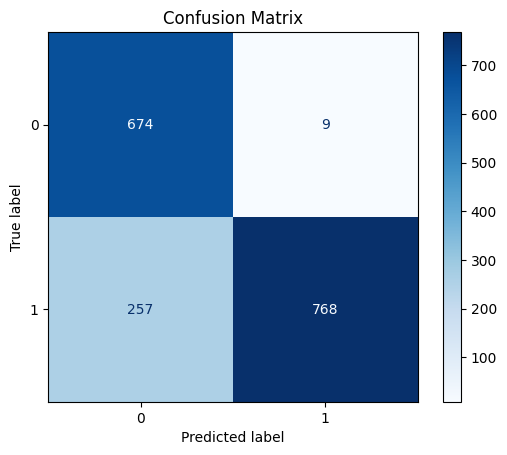

In [269]:
# LGBM Confusion Matrix

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### This matrix shows that the model correctly classified 674 of the class 0 (underperforming) cases and 768 of the class 1 (outperforming) cases, with a moderate number of false positives 9 and false negatives 257

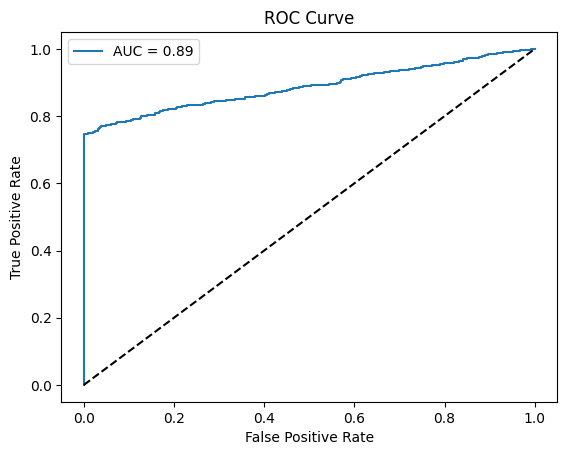

In [288]:
#LGBM ROC Curve

probs = LGBM.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


#### An AUC score of 0.89 indicates strong separability between the two classes showing that the model is capable of distinguishing good trading signals from poor ones

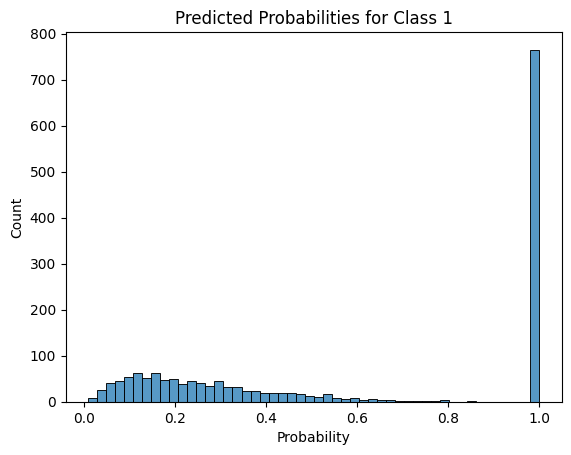

In [276]:
# LGBM Predicted Class 1 Probabilities

sns.histplot(probs, bins=50)
plt.title("Predicted Probabilities for Class 1")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()


#### This histogram shows the predicted probability distribution for the good crossover signals, class 1. The peak near 1.0 suggests high model confidence in many of its predictions with a long tail indicating varying uncertainty in other predictions

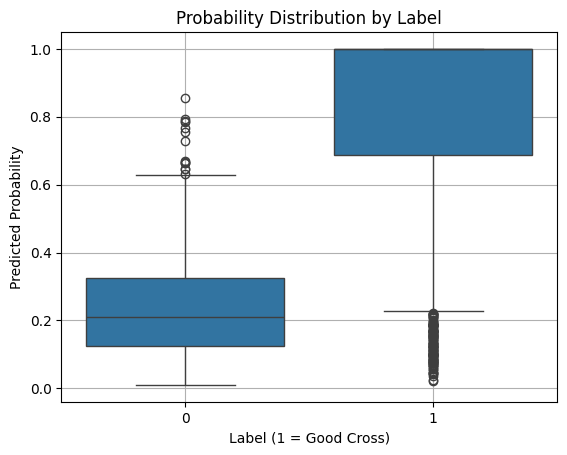

In [290]:
X_test_with_probs = X_test.copy()
X_test_with_probs['prob_1'] = probs
X_test_with_probs['label'] = y_test.values

sns.boxplot(x='label', y='prob_1', data=X_test_with_probs)
plt.title("Probability Distribution by Label")
plt.xlabel("Label (1 = Good Cross)")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.show()


#### This boxplot shows class 1 examples have significantly higher predicted probabilities compared to class 0, confirming that the model is correctly assigning higher confidence to truly positive cases while still maintaining a reasonable spread

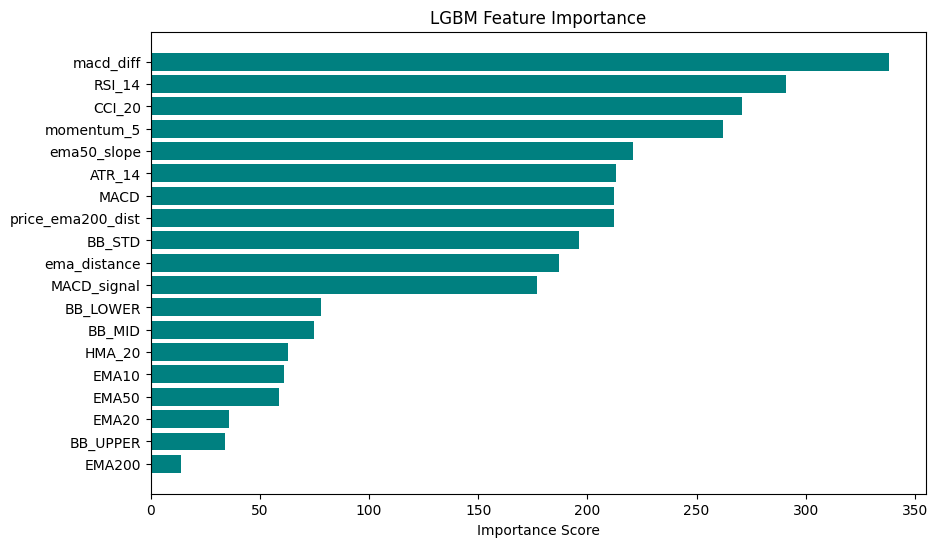

In [273]:
# Feature Importance

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': LGBM.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("LGBM Feature Importance")
plt.show()


#### This feature importance shows indicators like `macd_diff`, `RSI_14`, and `CCI_20` were the most influential in determining the class label, highlighting which technical indicators had the strongest predictive value

## Simulated Backtest

Once our champion model has been selected and evaluated its now time to test our predictions in a simulated backtest. Here's how it will flow:
- The backtest will be run on one stock, it will not be a portfolio backtest 
- Initial cash is set to $10,000
- A buy signal will be generated depending if the LGBM model predicted a good cross (class 1)
- A sell signal will be generated once EMA50 goes equal or below EMA200 (EMA50 <= EMA200)
- For every buy signal, purchase as much stock with the cash available (all in)
- For every sell signal, sell all stock

To emphasize, the goal of this backtest isn't to aim for a high return percentage, its to see if the model is able to learn the patterns that make a profitbale EMA crossover. Although, this strategy can be implemented with other strategies that would equate to a high cumulative return.

In [ ]:
tickers = sorted(df_flat['Ticker'].unique().tolist())
timeframe_options = {
    "All": None,
    "3 Months": 90,
    "9 Months": 270,
    "1 Year": 365,
    "3 Years": 365 * 3,
    "5 Years": 365 * 5
}

ticker_widget = widgets.Dropdown(options=tickers, description='Ticker:')
timeframe_widget = widgets.Dropdown(options=list(timeframe_options.keys()), description='Timeframe:')
run_button = widgets.Button(description='Run', button_style='success')
output = widgets.Output()


def on_run_clicked(b):
    with output:
        clear_output(wait=True)
        
        ticker = ticker_widget.value
        days = timeframe_options[timeframe_widget.value]
        
        df = df_flat[df_flat['Ticker'] == ticker].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        if days:
            cutoff = df['Date'].max() - timedelta(days=days)
            df = df[df['Date'] >= cutoff]

        X_cols = LGBM.feature_name_ if hasattr(LGBM, 'feature_name_') else df.columns.difference(['Date', 'Ticker', 'label'])
        df['predicted_proba'] = LGBM.predict_proba(df[X_cols])[:, 1]
        crosses = df[df['crossover']].copy()
        crosses = crosses[['Date', 'Ticker', 'Close', 'predicted_proba', 'label']]

        # Simulated backtest
        initial_cash = 10000
        cash = initial_cash
        position = 0
        holding = False
        buy_price = 0
        trade_log = []

        df['position_value'] = 0.0
        df['buy_signal'] = False
        df['sell_signal'] = False

        for i in range(len(df)):
            row = df.iloc[i]
            if not holding and row['crossover'] and row['label'] == 1:
                position = cash / row['Close']
                buy_price = row['Close']
                cash = 0
                holding = True
                df.at[df.index[i], 'buy_signal'] = True
                trade_log.append({
                    'Date': row['Date'],
                    'Action': 'Buy',
                    'Buy Price': round(buy_price, 2),
                    'Sell Price': None,
                    'Profit %': None
                })
            elif holding and row['EMA50'] <= row['EMA200']:
                sell_price = row['Close']
                cash = position * sell_price
                profit_pct = ((sell_price - buy_price) / buy_price) * 100
                holding = False
                position = 0
                df.at[df.index[i], 'sell_signal'] = True
                trade_log.append({
                    'Date': row['Date'],
                    'Action': 'Sell',
                    'Buy Price': None,
                    'Sell Price': round(sell_price, 2),
                    'Profit %': f"{round(profit_pct, 2)}%"
                })
            df.at[df.index[i], 'position_value'] = position * row['Close'] if holding else cash

        final_value = df['position_value'].iloc[-1]
        cumulative_return = (final_value - initial_cash) / initial_cash * 100

        plt.figure(figsize=(14, 6))
        plt.plot(df['Date'], df['Close'], label='Close', color='black')
        plt.plot(df['Date'], df['EMA50'], label='EMA50', color='deepskyblue')
        plt.plot(df['Date'], df['EMA200'], label='EMA200', color='orange')
        plt.scatter(df[df['crossover'] & (df['label'] == 1)]['Date'], 
                    df[df['crossover'] & (df['label'] == 1)]['Close'], 
                    color='green', marker='^', label='Good Cross', zorder=5)
        plt.scatter(df[df['crossover'] & (df['label'] == 0)]['Date'], 
                    df[df['crossover'] & (df['label'] == 0)]['Close'], 
                    color='red', marker='v', label='Bad Cross', zorder=5)

        for d in df[df['buy_signal']]['Date']:
            plt.axvline(d, color='green', linestyle='--', linewidth=1.5)
        for d in df[df['sell_signal']]['Date']:
            plt.axvline(d, color='red', linestyle='--', linewidth=1.5)

        buy_line = mlines.Line2D([], [], color='green', linestyle='--', label='Buy Signal')
        sell_line = mlines.Line2D([], [], color='red', linestyle='--', label='Sell Signal')

        plt.title(f"{ticker} EMA Crossover Strategy")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
        plt.grid(True)
        plt.legend(loc='upper left', handles=[
            plt.Line2D([], [], color='black', label='Close'),
            plt.Line2D([], [], color='blue', label='EMA50'),
            plt.Line2D([], [], color='orange', label='EMA200'),
            mlines.Line2D([], [], color='green', marker='^', linestyle='None', label='Good Cross'),
            mlines.Line2D([], [], color='red', marker='v', linestyle='None', label='Bad Cross'),
            buy_line,
            sell_line
        ])
        plt.show()

        display(crosses.sort_values('Date'))
        print(f"\nFinal Portfolio Value: ${final_value:,.2f}")
        print(f"Cumulative Return: {cumulative_return:.2f}%")

        trade_df = pd.DataFrame(trade_log)
        print("\nTrade Log:")
        trade_df = trade_df.fillna('')
        display(trade_df)

run_button.on_click(on_run_clicked)
display(widgets.VBox([ticker_widget, timeframe_widget, run_button]), output)

Output()

## Conclusion

This notebook explored a data driven approach to identifying profitable EMA crossover events using machine learning. By engineering features from common technical indicators and training a LightGBM classifier, we were able to isolate high probability "good" crossovers across S&P 500 stocks.

The model achieved an accuracy of 84%, with a fair balance between precision and recall for good crossover signals. Feature importance analysis confirmed that MACD divergence, RSI(14), and CCI(20) were key drivers in identifying profitable trades.

To test this model in a realistic trading scenario, we created a simulated backtest where trades were initiated at model predicted "good" crossovers and exited when EMA50 dropped below or on par to EMA200. Most of the "good" crossovers became quite profitable and the "bad" crosses were mostly unsuccessful achieving little profit or loss.

## Insights & Opportunities

- Its visible that the model struggles identifying "good" and "bad" crossovers when the stock price is in consolidation, in other words when the price is moving sideways trying to figure out which direction to go. Its understandable why the model struggles in this situation, the model possibly needs access to more technical indicators or a hard coded logic setup that helps deal with this type of situation. 

- Further setup to the backtest can be done focusing on the sell signal as it is quite lagging behind. Additionally, the buy signal is also lagging as by the time the "good" cross have formed there is quite a gap from the most recent lowest price point. If we were able to adjust these signals accordingly it would account for more profitable trades.

- The buy and sell signal can be further improved when dealing with a portfolio, so you can weigh the amount of shares to allocate for each stock. Additional macro economics data and/or industry based data could prove to be helpful with this.

- A negative aspect on this strategy is that these crossovers don't happen often so your forced to only think long term. A combination of some short term strategy with this long term approach would support a much higher cumulative return.

- This framework can be easily adapted to include other strategies; and be used in live trading platforms. 

- This setup can also be engineered into a stock screener where a system scans and predicts the success probability of any crossovers that occur between the EMA50 and the EMA200 for all live trading stocks.


Concluding, this notebook serves as a strong foundation for building machine learning enhanced technical trading systems, transforming a basic EMA crossover into a more robust and informed decision engine.